In [ ]:
# ==============================
# 0. INSTALL & LOGIN
# ==============================
!pip install transformers==4.36.2 accelerate==0.25.0 huggingface_hub==0.19.4

In [9]:
import os

In [2]:
from huggingface_hub import login
login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
from huggingface_hub import whoami
whoami()


{'type': 'user',
 'id': '6978b2c8b4c7d9c8cffa5e98',
 'name': 'harneetkaur09',
 'fullname': 'Harneet Kaur',
 'isPro': False,
 'avatarUrl': '/avatars/00ebbeec4aa2adcfa149f9c605141f8a.svg',
 'orgs': [],
 'auth': {'type': 'access_token',
  'accessToken': {'displayName': 'streamlit-mentalbert',
   'role': 'fineGrained',
   'createdAt': '2026-01-27T12:49:20.739Z',
   'fineGrained': {'canReadGatedRepos': True,
    'global': [],
    'scoped': [{'entity': {'_id': '6978b2c8b4c7d9c8cffa5e98',
       'type': 'user',
       'name': 'harneetkaur09'},
      'permissions': ['repo.content.read', 'repo.write']}]}}}}

In [4]:
# ==============================
# 1. IMPORTS & SETUP
# ==============================
import re
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


# ==============================
# 2. LOAD DATA
# ==============================
df = pd.read_csv("/kaggle/input/mental-health/compressed_data.csv")

df = df.rename(columns={"statement": "text", "status": "label"})
df = df.dropna(subset=["text", "label"])
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

label_names = sorted(df["label"].unique())
label2id = {l: i for i, l in enumerate(label_names)}
id2label = {i: l for l, i in label2id.items()}

df["label_id"] = df["label"].map(label2id)

print("Classes:", label2id)
print("Dataset shape:", df.shape)


# ==============================
# 3. MINIMAL CLEANING 
# ==============================
def minimal_clean(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|@\w+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text"] = df["text"].apply(minimal_clean)


# ==============================
# 4. TRAIN / TEST SPLIT (STRATIFIED)
# ==============================
train_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df["label_id"],
    random_state=SEED
)


# ==============================
# 5. TOKENIZER & DATASET
# ==============================
MODEL_BASE = "mental/mental-bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_BASE,
    token=os.environ["HF_TOKEN"]
)

class MentalDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=256
        )
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = MentalDataset(train_df["text"], train_df["label_id"])
test_ds  = MentalDataset(test_df["text"], test_df["label_id"])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32)


# ==============================
# 6. MODEL
# ==============================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_BASE,
    num_labels=7,
    id2label=id2label,
    label2id=label2id,
    token=os.environ["HF_TOKEN"]
).to(device)


# ==============================
# 7. CLASS WEIGHTED LOSS
# ==============================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label_id"]),
    y=train_df["label_id"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)


# ==============================
# 8. OPTIMIZER & SCHEDULER
# ==============================
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 3
)


# ==============================
# 9. STAGE 1: FREEZE BACKBONE (WARMUP)
# ==============================
for param in model.base_model.parameters():
    param.requires_grad = False

print("Backbone frozen — warmup training")

for epoch in range(1):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = criterion(outputs.logits, batch["labels"])
        loss.backward()

        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    print(f"[Warmup] Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 2
)

/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Device: cuda
Classes: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}
Dataset shape: (51073, 4)


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Backbone frozen — warmup training
[Warmup] Epoch 1 | Loss: 1.7093


In [5]:
# ==============================
# 10. STAGE 2: UNFREEZE & FINETUNE
# ==============================
for param in model.base_model.parameters():
    param.requires_grad = True

print("Backbone unfrozen — full fine-tuning")

for epoch in range(2):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = criterion(outputs.logits, batch["labels"])
        loss.backward()

        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    print(f"[Finetune] Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")


# ==============================
# 11. EVALUATION
# ==============================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(batch["labels"].cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=label_names))


# ==============================
# 12. SAVE & PUSH MODEL
# ==============================
MODEL_NAME = "harneetkaur09/mentalbert-mental-health"

model.save_pretrained(MODEL_NAME)
tokenizer.save_pretrained(MODEL_NAME)

from huggingface_hub import HfApi
api = HfApi()
api.create_repo(repo_id=MODEL_NAME, exist_ok=True)
api.upload_folder(folder_path=MODEL_NAME, repo_id=MODEL_NAME)

print("✅ Model trained, evaluated, and pushed to Hugging Face")


Backbone unfrozen — full fine-tuning
[Finetune] Epoch 1 | Loss: 0.5771
[Finetune] Epoch 2 | Loss: 0.3244
                      precision    recall  f1-score   support

             Anxiety       0.86      0.88      0.87       543
             Bipolar       0.81      0.86      0.83       375
          Depression       0.85      0.67      0.75      2263
              Normal       0.98      0.94      0.96      2406
Personality disorder       0.58      0.83      0.68       134
              Stress       0.66      0.88      0.75       344
            Suicidal       0.68      0.83      0.74      1596

            accuracy                           0.82      7661
           macro avg       0.77      0.84      0.80      7661
        weighted avg       0.84      0.82      0.82      7661



model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

✅ Model trained, evaluated, and pushed to Hugging Face


## Confusion Matrix

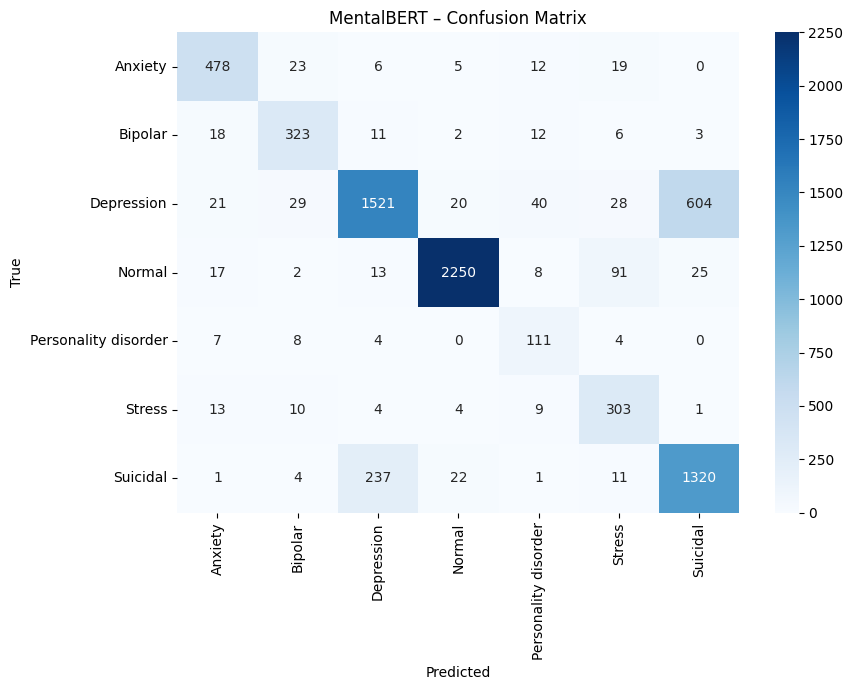

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(9,7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MentalBERT – Confusion Matrix")
plt.tight_layout()
plt.show()


## Per-class F1 Score Bar Chart

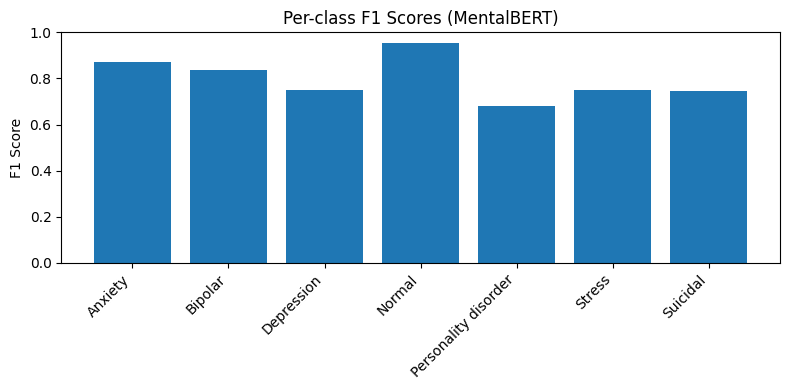

In [7]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(
    y_true, y_pred, target_names=label_names, output_dict=True
)

f1_scores = {
    label: report[label]["f1-score"]
    for label in label_names
}

plt.figure(figsize=(8,4))
plt.bar(f1_scores.keys(), f1_scores.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.title("Per-class F1 Scores (MentalBERT)")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


## True vs Predicted Class Distribution (bias check)

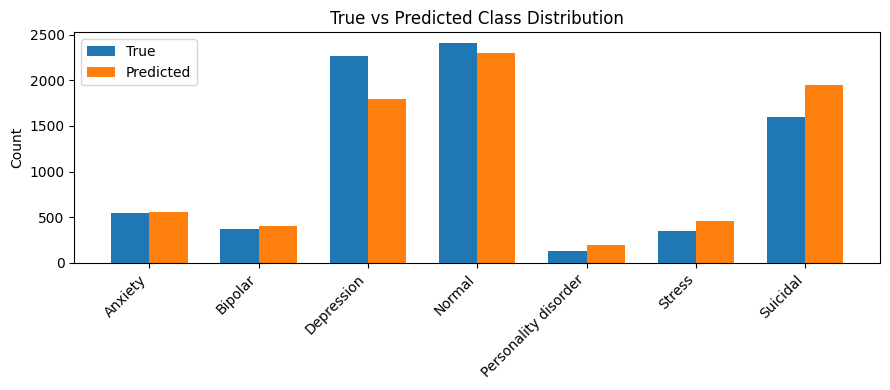

In [8]:
import numpy as np
from collections import Counter

true_counts = Counter(y_true)
pred_counts = Counter(y_pred)

labels = range(len(label_names))
true_vals = [true_counts[i] for i in labels]
pred_vals = [pred_counts[i] for i in labels]

x = np.arange(len(label_names))
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(x - width/2, true_vals, width, label="True")
plt.bar(x + width/2, pred_vals, width, label="Predicted")

plt.xticks(x, label_names, rotation=45, ha="right")
plt.ylabel("Count")
plt.title("True vs Predicted Class Distribution")
plt.legend()
plt.tight_layout()
plt.show()
